# Ensemble Learning Method
* In this notebook we will apply custom ensemble learning technique to classify images 
* 1- Use the feature extracted from ResNet deep learning model as Training dataset
* 2- Build ensemble contains list of  machine learning algorithm (DecisionTree, SVM), one classifier for each class
* 3- Train the ensemble using training dataset and one-versus-all approach 

## 1. Load the Featrues extracted from ResNet

* These features extracted in the notebook with name 'MessidorTesting' which can found in the same directory
* The features splitted into the following filese:
    * 1- trainset_as_vectorspkl: training dataset (kaggle version) 
    * 2- testset_as_vectors.pkl: testing dataset (kaggle version)
    * 3- messidor_as_vectors.pkl: train&test dataset (messidor2 dataset)

In [1]:
import pickle
from os.path import exists 

def load_dataset(path):
    """Load pickle files """
    
    if not exists(path):
        raise FileNotFoundError(rrno.ENOENT, os.strerror(errno.ENOENT), path) 
    # if file exsits
    with open('{}'.format(path), 'rb') as in_file:
        dataset = pickle.load(in_file)
        return dataset
    return None 

In [2]:
X_train_kaggle = load_dataset('X_train_kaggle.pkl')
X_test_kaggle = load_dataset('X_test_kaggle.pkl')

In [3]:
X_train_messidor = load_dataset('dataset/X_train_messidor.pkl')
X_test_messidor = load_dataset('dataset/X_test_messidor.pkl')

# 2. Build The Ensemble

* Use the same training algorithm for every predictor, but to train them on different random subsets of the training set
* We will build two versions of ensemble one with DT and another with SVM

In [5]:
from sklearn.model_selection import train_test_split
import numpy as np 
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm

class Ensemble:
    def __init__(self, classifiers: list, algorithm:str='bagging', n_jobs:int=1):
        """
        classifiers: list of machine learning classifiers used in the ensemble
        algorithm: string value on of the two possible values : ['bagging', 'pasting'], 
                    when bagging is used sampling is performed with replacement, pasting without replacement
        n_jobs: number of core to use in parallel execution.
        """
        self.classifiers = classifiers
        self.algorithm = algorithm
        self.fitted = False
    
    
    def one_versus_rest(self, y, positive_class):
        positive_class_indices = np.where(y == positive_class)[0]
        negative_class_indices = list(set(range(y.shape[0])) - set(positive_class_indices.tolist()))
        y[positive_class_indices] = 1
        y[negative_class_indices] = 0
        return y
        
        
    def fit(self, X_train, y_train):
        """
        """
        if X_train.shape[0] != y_train.shape[0]:
            raise Error('The number of instance in the X_train must be the same as y_train but found \
                    {0} sample in X_train and {1} in y_train'.format(X_train.shape[0], y_train.shape[0]))
        
        for i, clf in enumerate(self.classifiers):
            y_train_copy = self.one_versus_rest(y_train.copy(), i)
            random_state = np.random.randint(0, 200, 1)[0]
            X_train_, _, y_train_, _ = train_test_split(X_train, y_train_copy, random_state=random_state,
                                                        test_size=0.1, shuffle=True)
            
            clf.fit(X_train_, y_train_)
        
    def predict(self, X):
        prediction = []
        for clf in self.classifiers:
            prediction.append(clf.predict_proba(X)[:, 1])
        return np.array(prediction).argmax(axis=0)

In [7]:
y_train_kaggle = []

num_of_samples = [len(os.listdir('dataset/train/class_{}'.format(i))) for i in range(5) ]
for i, num in enumerate(num_of_samples):
    y_train_kaggle += [i] * num
    
y_train_kaggle = np.array(y_train_kaggle)
X_train_kaggle = np.array(X_train_kaggle)

print('X_train shape : {}'.format(X_train_kaggle.shape))
print('y_train shape : {}'.format(y_train_kaggle.shape))

X_train shape : (28451, 2048)
y_train shape : (28451,)


In [8]:
X_test_kaggle = np.array(X_test_kaggle)

In [ ]:
classifiers = [svm.SVC(decision_function_shape='ovo', max_iter=10000, C=0.7, probability=True), 
              svm.SVC(decision_function_shape='ovo', max_iter=10000, C=0.7, probability=True),
              svm.SVC(decision_function_shape='ovo', max_iter=10000, C=0.7, probability=True), 
              svm.SVC(decision_function_shape='ovo', max_iter=10000, C=0.7, probability=True),
              svm.SVC(decision_function_shape='ovo', max_iter=10000, C=0.7, probability=True)]

ensemble = Ensemble(classifiers)
ensemble.fit(X_train_kaggle, y_train_kaggle)

In [13]:
y_pred = ensemble.predict(X_test_kaggle)

In [14]:
np.unique(y_pred, return_counts=True)

(array([0, 1, 2, 3, 4]), array([2952,   46,  445,   41,   29]))

In [15]:
y_test_kaggle = []
for i in range(5):
    imgs = os.listdir(os.path.join('dataset', 'test', 'class_{}'.format(i)))
    y_test_kaggle += [i] * len(imgs)
y_test_kaggle = np.array(y_test_kaggle)


In [16]:
np.unique(y_test_kaggle, return_counts=True)

(array([0, 1, 2, 3, 4]), array([2574,  247,  541,   77,   74]))

In [10]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix, cohen_kappa_score,accuracy_score
from sklearn.metrics import roc_curve, auc
import pandas as pd 
import matplotlib.pyplot as plt 

def plot_conf_matrix(true, pred, classes):
    cf = confusion_matrix(true, pred)
    plt.figure(figsize=(12,10))
    sns.set(font_scale=1.4)
    sns.heatmap(np.round(cf / cf.sum(axis=0), 2), annot=True, annot_kws={"size": 16},fmt='g',
                cmap='Blues', xticklabels = classes ,yticklabels = classes)
    plt.show()

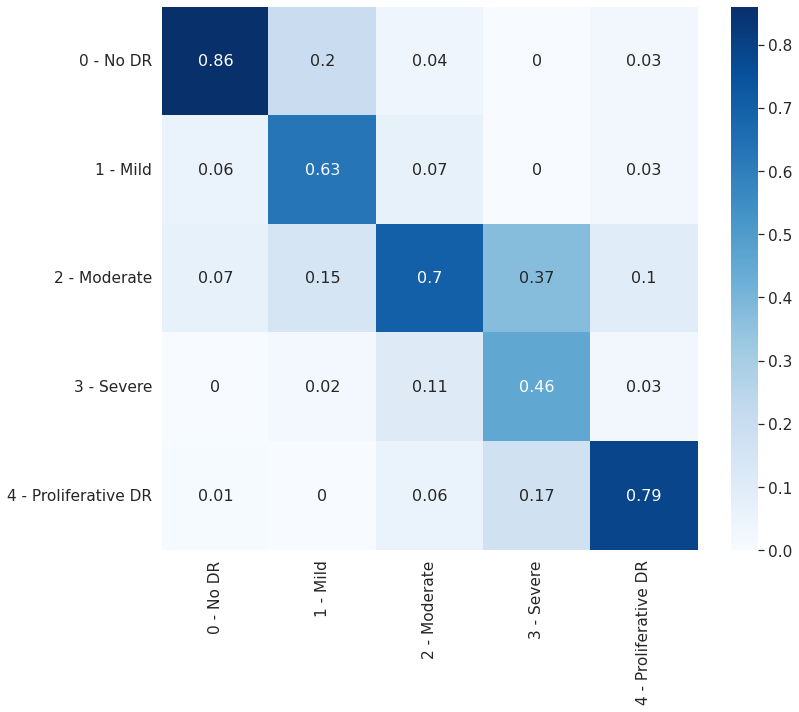

In [18]:
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
plot_conf_matrix(y_test_kaggle, y_pred, labels)

In [10]:
classifiers1 = [DecisionTreeClassifier(max_depth=8, min_samples_leaf=15, random_state=42, max_features=20),
              DecisionTreeClassifier(max_depth=8, min_samples_leaf=15, random_state=42, max_features=20),
              DecisionTreeClassifier(max_depth=12, min_samples_leaf=15, random_state=42, max_features=1000),
              DecisionTreeClassifier(max_depth=18, min_samples_leaf=15, random_state=42, max_features=1000),
              DecisionTreeClassifier(max_depth=12, min_samples_leaf=15, random_state=42, max_features=1000),]

ensemble1 = Ensemble(classifiers1)
ensemble1.fit(X_train_kaggle, y_train_kaggle)

In [25]:
y_pred = ensemble1.predict(X_test_kaggle)

In [26]:
np.unique(y_pred, return_counts=True)

(array([0, 1, 2, 3, 4]), array([2859,   74,  467,   63,   50]))

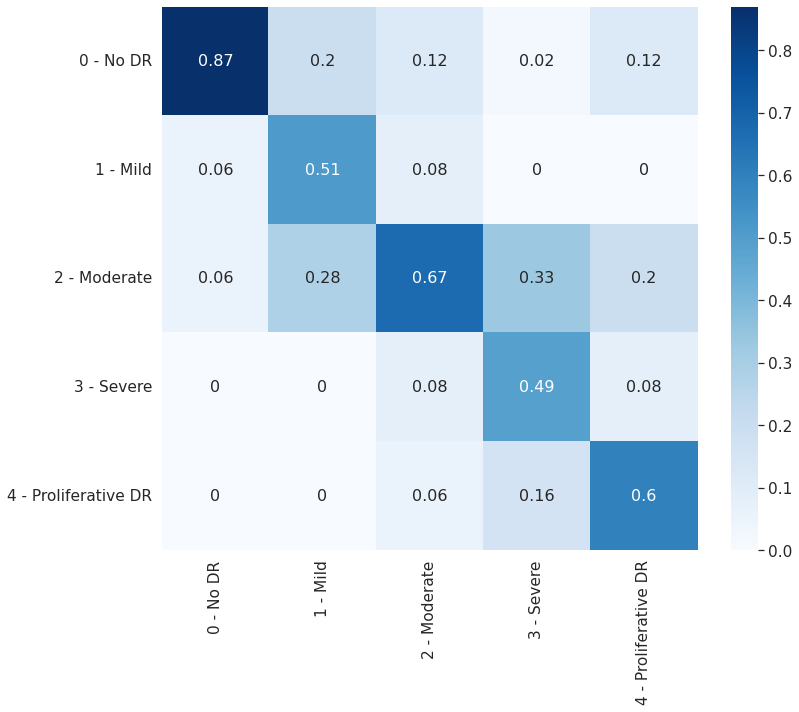

In [27]:
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
plot_conf_matrix(y_test_kaggle, y_pred, labels)

# Messidor testing 

In [7]:
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']

In [6]:
X_train_messidor = np.array(X_train_messidor)
y_train_messidor = []

for i in range(5):
    imgs = os.listdir(os.path.join('messidor_dataset', 'messidor2/ProcessedImages', 'train', 'class_{}'.format(i)))
    y_train_messidor += [i] * len(imgs)
    
y_test_messidor = []

for i in range(5):
    imgs = os.listdir(os.path.join('messidor_dataset', 'messidor2/ProcessedImages', 'test', 'class_{}'.format(i)))
    y_test_messidor += [i] * len(imgs)
    
y_train_messidor = np.array(y_train_messidor)
y_test_messidor = np.array(y_test_messidor)

In [56]:
classifiers2 = [svm.SVC(decision_function_shape='ovo', max_iter=10000, C=0.7, probability=True), 
              svm.SVC(decision_function_shape='ovo', max_iter=10000, C=0.7, probability=True),
              svm.SVC(decision_function_shape='ovo', max_iter=10000, C=0.7, probability=True), 
              svm.SVC(decision_function_shape='ovo', max_iter=10000, C=0.7, probability=True),
              svm.SVC(decision_function_shape='ovo', max_iter=10000, C=0.2, probability=True)]

ensemble2 = Ensemble(classifiers2)
ensemble2.fit(X_train_messidor, y_train_messidor)

In [57]:
y_pred_messidor = ensemble2.predict(X_test_messidor)

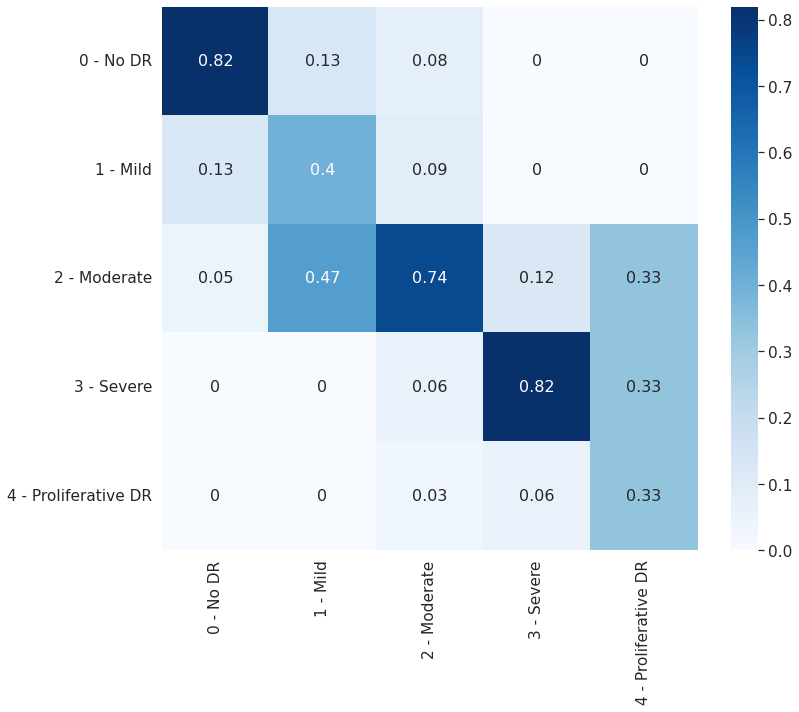

In [58]:

plot_conf_matrix(y_test_messidor, y_pred_messidor, labels)

In [50]:
# ensemble with decision tree classifiers 


classifiers3 = [DecisionTreeClassifier(max_depth=8, min_samples_leaf=15, random_state=42, max_features=20),
              DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, random_state=42, max_features=20),
              DecisionTreeClassifier(max_depth=12, min_samples_leaf=15, random_state=42, max_features=1000),
              DecisionTreeClassifier(max_depth=8, min_samples_leaf=15, random_state=42, max_features=1000),
              DecisionTreeClassifier(max_depth=12, min_samples_leaf=8, random_state=42, max_features=20)]

ensemble3 = Ensemble(classifiers3)
ensemble3.fit(X_train_messidor, y_train_messidor)

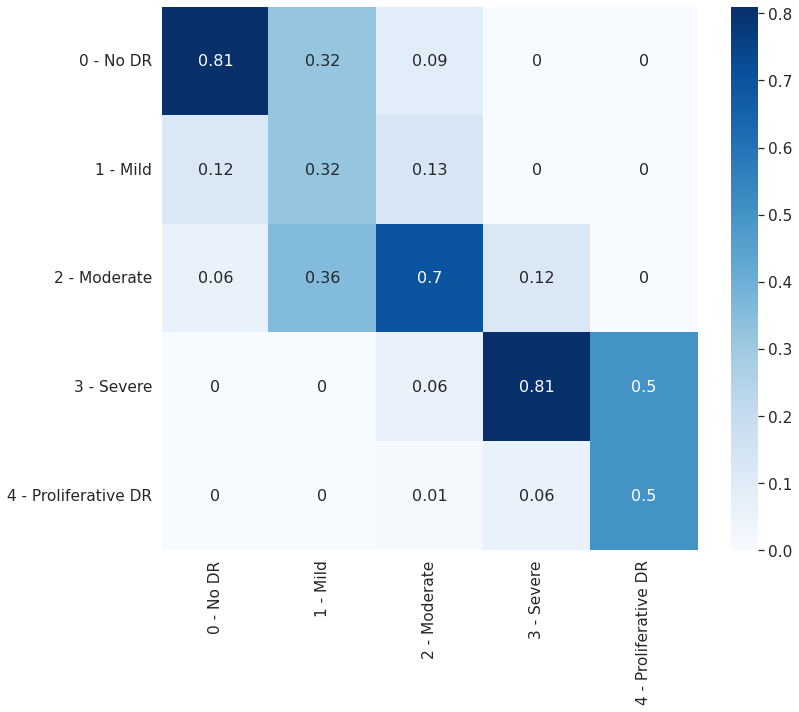

In [51]:
y_pred_messidor = ensemble3.predict(X_test_messidor)
plot_conf_matrix(y_test_messidor, y_pred_messidor, labels)

In [ ]:
'gfdgDF'